In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

from sklearn.metrics import roc_auc_score
from sklearn.covariance import EmpiricalCovariance

PROJECT_ROOT = Path(r"C:\Users\othni\Projects\mvtec_ad")
DATA_ROOT = PROJECT_ROOT / "data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
df_all = pd.read_csv(PROJECT_ROOT / "experiments" / "image_level_df.csv")

df_bottle = df_all[df_all["category"] == "bottle"].copy()
df_bottle.head(), df_bottle["label"].value_counts()

(                                                path category  split  label  \
 0  C:\Users\othni\Projects\mvtec_ad\data\bottle\t...   bottle  train      0   
 1  C:\Users\othni\Projects\mvtec_ad\data\bottle\t...   bottle  train      0   
 2  C:\Users\othni\Projects\mvtec_ad\data\bottle\t...   bottle  train      0   
 3  C:\Users\othni\Projects\mvtec_ad\data\bottle\t...   bottle  train      0   
 4  C:\Users\othni\Projects\mvtec_ad\data\bottle\t...   bottle  train      0   
 
   defect_type final_split  
 0        good       train  
 1        good       train  
 2        good       train  
 3        good       train  
 4        good       train  ,
 label
 0    229
 1     63
 Name: count, dtype: int64)

In [3]:
df_bottle_train = df_bottle[(df_bottle["split"] == "train") & (df_bottle["label"] == 0)].copy()
df_bottle_test  = df_bottle[df_bottle["split"] == "test"].copy()

print("Train bottle (good only) :", df_bottle_train.shape)
print("Test bottle (good + défauts) :", df_bottle_test.shape)
print("\nTest label counts:")
print(df_bottle_test["label"].value_counts())
print("\nTest defect_types:")
print(df_bottle_test["defect_type"].value_counts())

Train bottle (good only) : (209, 6)
Test bottle (good + défauts) : (83, 6)

Test label counts:
label
1    63
0    20
Name: count, dtype: int64

Test defect_types:
defect_type
broken_small     22
contamination    21
broken_large     20
good             20
Name: count, dtype: int64


In [4]:
class BottleDatasetAD(Dataset):
    def __init__(self, df_split, transform=None):
        self.df = df_split.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = Path(row["path"])
        label = int(row["label"])   # 0 = normal, 1 = anomalie

        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [5]:
eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_ds_bottle = BottleDatasetAD(df_bottle_train, transform=eval_transform)
test_ds_bottle  = BottleDatasetAD(df_bottle_test,  transform=eval_transform)

train_loader_bottle = DataLoader(train_ds_bottle, batch_size=32, shuffle=False, num_workers=0)
test_loader_bottle  = DataLoader(test_ds_bottle,  batch_size=32, shuffle=False, num_workers=0)

len(train_ds_bottle), len(test_ds_bottle)

(209, 83)

In [6]:
resnet_feat = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# On enlève la dernière couche fc, on garde tout le reste
modules = list(resnet_feat.children())[:-1]   # tout sauf la couche fc
resnet_feat = nn.Sequential(*modules).to(device)
resnet_feat.eval()

# Vérif rapide forme des features
dummy = torch.zeros(1, 3, 224, 224).to(device)
with torch.no_grad():
    feat = resnet_feat(dummy)  # (1, 512, 1, 1)
print("Shape feature:", feat.shape)

Shape feature: torch.Size([1, 512, 1, 1])


In [7]:
def extract_features(loader):
    all_feats = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            feat = resnet_feat(imgs)               # (B, 512, 1, 1)
            feat = feat.view(feat.size(0), -1)     # (B, 512)
            all_feats.append(feat.cpu().numpy())
            all_labels.append(labels.numpy())
    feats = np.concatenate(all_feats, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    return feats, labels

train_feats_bottle, train_labels_bottle = extract_features(train_loader_bottle)
test_feats_bottle,  test_labels_bottle  = extract_features(test_loader_bottle)

train_feats_bottle.shape, test_feats_bottle.shape

((209, 512), (83, 512))

In [8]:
# On ne prend que les features des images normales (label 0) pour l'AD
normal_feats = train_feats_bottle[train_labels_bottle == 0]

print("Normal feats shape:", normal_feats.shape)

cov = EmpiricalCovariance().fit(normal_feats)

mu = cov.location_          # moyenne (512,)
Sigma_inv = cov.precision_  # inverse de covariance (512x512)

Normal feats shape: (209, 512)


In [9]:
def mahalanobis_scores(X, mu, Sigma_inv):
    # X : (N, D)
    diff = X - mu
    # score_i = sqrt( (x - mu)^T Sigma_inv (x - mu) )
    left = np.dot(diff, Sigma_inv)
    m = np.sqrt(np.sum(left * diff, axis=1))
    return m

train_scores = mahalanobis_scores(train_feats_bottle, mu, Sigma_inv)
test_scores  = mahalanobis_scores(test_feats_bottle,  mu, Sigma_inv)

train_scores.shape, test_scores.shape

((209,), (83,))

Bottle AD (Mahalanobis on ResNet features) - Test AUROC: 0.9952380952380953


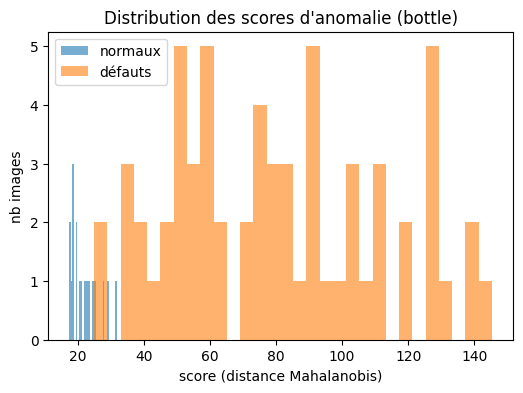

In [10]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Label 0 = normal, 1 = anomalie
auc_test = roc_auc_score(test_labels_bottle, test_scores)
print("Bottle AD (Mahalanobis on ResNet features) - Test AUROC:", auc_test)

plt.figure(figsize=(6,4))
plt.hist(test_scores[test_labels_bottle == 0], bins=30, alpha=0.6, label="normaux")
plt.hist(test_scores[test_labels_bottle == 1], bins=30, alpha=0.6, label="défauts")
plt.legend()
plt.title("Distribution des scores d'anomalie (bottle)")
plt.xlabel("score (distance Mahalanobis)")
plt.ylabel("nb images")
plt.show()

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

scores = test_scores
y_true = test_labels_bottle

taus = np.linspace(scores.min(), scores.max(), 500)
rows = []

for tau in taus:
    y_pred = (scores >= tau).astype(int)  # score élevé => anomalie
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)
    f2        = fbeta_score(y_true, y_pred, beta=2, zero_division=0)
    rows.append({
        "tau": tau,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "f2": f2,
    })

res_bottle = pd.DataFrame(rows)
res_bottle.head()

,tau,precision,recall,f1,f2
0,17.425904,0.759036,1.0,0.863014,0.940299
1,17.682315,0.768293,1.0,0.868966,0.943114
2,17.938726,0.777778,1.0,0.875000,0.945946
3,18.195137,0.787500,1.0,0.881119,0.948795
4,18.451547,0.787500,1.0,0.881119,0.948795


In [12]:
i_f1 = res_bottle["f1"].idxmax()
i_f2 = res_bottle["f2"].idxmax()

row_f1_b = res_bottle.loc[i_f1]
row_f2_b = res_bottle.loc[i_f2]

print("=== Bottle AD - Max F1 ===")
print(row_f1_b)

print("\n=== Bottle AD - Max F2 ===")
print(row_f2_b)

# Mode safe : rappel = 1.0 si possible
safe_candidates_b = res_bottle[res_bottle["recall"] == 1.0]
print("\nNb seuils bottle avec recall=1.0 :", len(safe_candidates_b))

if len(safe_candidates_b) > 0:
    i_safe_b = safe_candidates_b["f1"].idxmax()
    row_safe_b = res_bottle.loc[i_safe_b]
else:
    row_safe_b = row_f2_b

print("\n=== Bottle AD - SAFE ===")
print(row_safe_b)

=== Bottle AD - Max F1 ===
tau          32.041318
precision     1.000000
recall        0.968254
f1            0.983871
f2            0.974441
Name: 57, dtype: float64

=== Bottle AD - Max F2 ===
tau          24.861817
precision     0.940299
recall        1.000000
f1            0.969231
f2            0.987461
Name: 29, dtype: float64

Nb seuils bottle avec recall=1.0 : 30

=== Bottle AD - SAFE ===
tau          24.861817
precision     0.940299
recall        1.000000
f1            0.969231
f2            0.987461
Name: 29, dtype: float64


In [13]:
from torchvision import models
from torch import nn
import numpy as np

# Modèle classifieur image-level global entraîné (ResNet18)
cls_model = models.resnet18(weights=None)
in_features = cls_model.fc.in_features
cls_model.fc = nn.Linear(in_features, 1)

cls_ckpt = PROJECT_ROOT / "models" / "resnet18_image_level_best.pt"
cls_model.load_state_dict(torch.load(cls_ckpt, map_location=device))
cls_model = cls_model.to(device)
cls_model.eval()

cls_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
cls_logits_list = []
cls_labels_list = []

with torch.no_grad():
    for imgs, labels in test_loader_bottle:
        imgs = imgs.to(device)
        logits = cls_model(imgs).squeeze(1)
        cls_logits_list.append(logits.cpu().numpy())
        cls_labels_list.append(labels.numpy())

cls_logits = np.concatenate(cls_logits_list)          # (83,)
cls_probs  = 1 / (1 + np.exp(-cls_logits))            # sigmoid
cls_labels = np.concatenate(cls_labels_list)          # (83,)

print("cls_probs shape:", cls_probs.shape)
print("same labels as test_labels_bottle ?",
      np.all(cls_labels == test_labels_bottle))

cls_probs shape: (83,)
same labels as test_labels_bottle ? True


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, confusion_matrix

tau_img_F1   = 0.82     # de ton fichier thresholds
tau_img_safe = 0.023
tau_ad_safe  = float(row_safe_b["tau"])      # 24.8618
tau_ad_F1    = float(row_f1_b["tau"])        # 32.041318

print("tau_img_F1  =", tau_img_F1)
print("tau_img_safe=", tau_img_safe)
print("tau_ad_safe =", tau_ad_safe)
print("tau_ad_F1   =", tau_ad_F1)

def eval_preds(y_true, y_pred, name=""):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)
    f2        = fbeta_score(y_true, y_pred, beta=2, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"\n=== {name} ===")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1        : {f1:.4f}")
    print(f"F2        : {f2:.4f}")
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    return dict(precision=precision, recall=recall, f1=f1, f2=f2,
                tn=tn, fp=fp, fn=fn, tp=tp)

# Scores AD (déjà calculés) : test_scores, test_labels_bottle
ad_pred_safe = (test_scores >= tau_ad_safe).astype(int)
ad_pred_F1   = (test_scores >= tau_ad_F1).astype(int)

# Scores classifieur global
cls_pred_F1   = (cls_probs >= tau_img_F1).astype(int)
cls_pred_safe = (cls_probs >= tau_img_safe).astype(int)

res_ad_safe   = eval_preds(test_labels_bottle, ad_pred_safe,   "AD bottle SAFE")
res_ad_F1     = eval_preds(test_labels_bottle, ad_pred_F1,     "AD bottle F1*")
res_cls_F1    = eval_preds(test_labels_bottle, cls_pred_F1,    "ResNet global F1* (bottle)")
res_cls_safe  = eval_preds(test_labels_bottle, cls_pred_safe,  "ResNet global SAFE (bottle)")

tau_img_F1  = 0.82
tau_img_safe= 0.023
tau_ad_safe = 24.861816682001834
tau_ad_F1   = 32.04131840277652

=== AD bottle SAFE ===
Precision : 0.9403
Recall    : 1.0000
F1        : 0.9692
F2        : 0.9875
TN=16, FP=4, FN=0, TP=63

=== AD bottle F1* ===
Precision : 1.0000
Recall    : 0.9683
F1        : 0.9839
F2        : 0.9744
TN=20, FP=0, FN=2, TP=61

=== ResNet global F1* (bottle) ===
Precision : 1.0000
Recall    : 0.9841
F1        : 0.9920
F2        : 0.9873
TN=20, FP=0, FN=1, TP=62

=== ResNet global SAFE (bottle) ===
Precision : 0.8873
Recall    : 1.0000
F1        : 0.9403
F2        : 0.9752
TN=12, FP=8, FN=0, TP=63


In [16]:
# Cascade 1 : AD SAFE + ResNet F1* (AND)
cascade_pred_AND = ((test_scores >= tau_ad_safe) & (cls_probs >= tau_img_F1)).astype(int)

res_cascade_AND = eval_preds(test_labels_bottle, cascade_pred_AND,
                             "Cascade AND = AD_SAFE AND ResNet_F1*")


=== Cascade AND = AD_SAFE AND ResNet_F1* ===
Precision : 1.0000
Recall    : 0.9841
F1        : 0.9920
F2        : 0.9873
TN=20, FP=0, FN=1, TP=62


In [17]:
tau_stage2_cascade = 0.60  # plus tolérant que 0.82

cascade_pred_AND_soft = ((test_scores >= tau_ad_safe) & (cls_probs >= tau_stage2_cascade)).astype(int)

res_cascade_AND_soft = eval_preds(test_labels_bottle, cascade_pred_AND_soft,
                                  "Cascade AND (stage2=0.60)")


=== Cascade AND (stage2=0.60) ===
Precision : 1.0000
Recall    : 0.9841
F1        : 0.9920
F2        : 0.9873
TN=20, FP=0, FN=1, TP=62


In [18]:
# Cascade 2 : OR (au cas où AD raterait un défaut)
cascade_pred_OR = ((test_scores >= tau_ad_safe) | (cls_probs >= tau_img_F1)).astype(int)

res_cascade_OR = eval_preds(test_labels_bottle, cascade_pred_OR,
                            "Cascade OR = AD_SAFE OR ResNet_F1*")


=== Cascade OR = AD_SAFE OR ResNet_F1* ===
Precision : 0.9403
Recall    : 1.0000
F1        : 0.9692
F2        : 0.9875
TN=16, FP=4, FN=0, TP=63
